In [9]:
import pandas as pd
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time
import tracemalloc

In [10]:
file_path = r'C:\Users\Χριστόδουλος\Desktop\ML project\cleaned_energy_data.csv'
df = pd.read_csv(file_path)

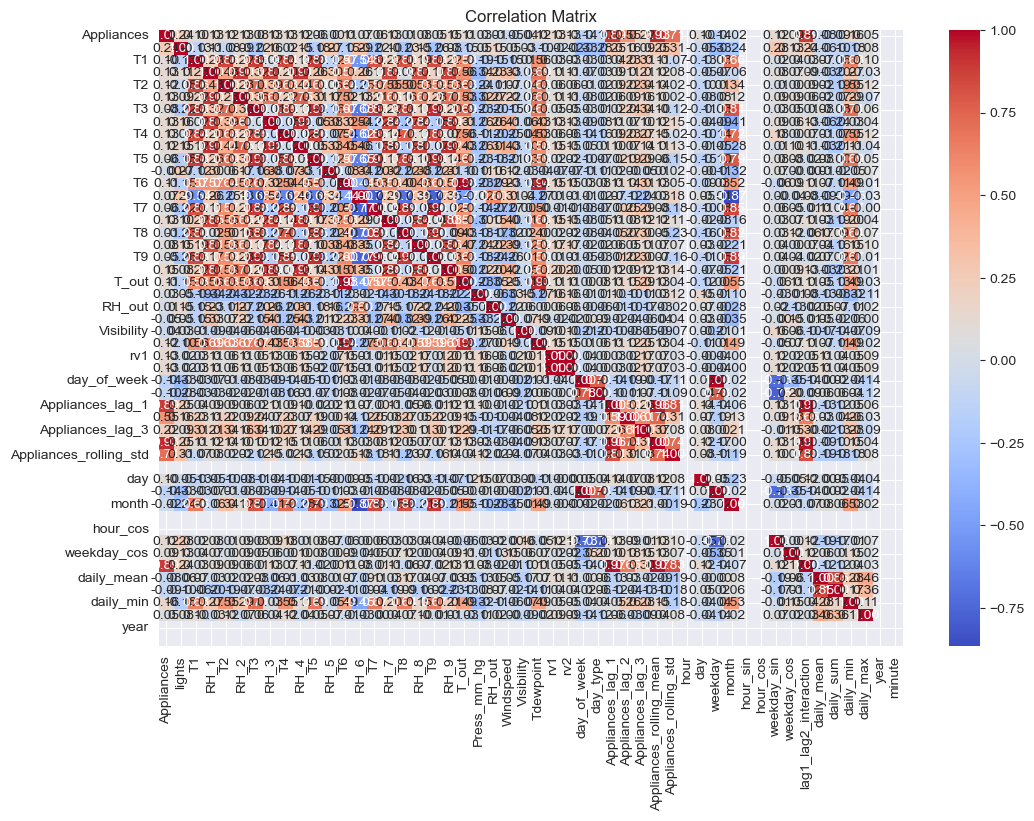

Correlation with the target (Appliances):
 Appliances                 1.000000
Appliances_rolling_mean    0.934184
lag1_lag2_interaction      0.887845
Appliances_lag_1           0.886331
Appliances_rolling_std     0.714728
Appliances_lag_2           0.550357
lights                     0.240588
Appliances_lag_3           0.220215
daily_min                  0.161747
RH_9                       0.146015
RH_1                       0.132662
RH_3                       0.132625
rv2                        0.132583
rv1                        0.132583
T4                         0.127248
RH_7                       0.127104
RH_2                       0.126774
Tdewpoint                  0.123026
weekday_sin                0.121812
T2                         0.121791
RH_4                       0.117814
T6                         0.111747
T_out                      0.107573
T1                         0.097193
day                        0.096454
weekday_cos                0.090925
T3                   

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df.drop(columns=['date'])

label_encoder = LabelEncoder()
df['day_type'] = label_encoder.fit_transform(df['day_type'])

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

target_correlation = correlation_matrix["Appliances"].sort_values(ascending=False)
print("Correlation with the target (Appliances):\n", target_correlation)

selected_features = target_correlation[target_correlation.abs() > 0.2].index.tolist()
selected_features.remove("Appliances")

X = df[selected_features]
y = df["Appliances"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
start_time = time.time()
tracemalloc.start()

GBM_regressor = sklearn.ensemble.GradientBoostingRegressor()
GBM_regressor.fit(X_train, y_train)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

y_pred = GBM_regressor.predict(X_test)

In [13]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE (%):", mape)
print("R²:", r2)
print("Training time (s):", end_time - start_time)
print("Memory usage (Bytes):", current)

RMSE: 8.100254626478874
MAE: 4.384516290564934
MAPE (%): 8.274444925169492
R²: 0.45464981340995503
Training time (s): 0.2552311420440674
Memory usage (Bytes): 47609


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
scores = cross_val_score(GBM_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated RMSE:", (-scores.mean())**0.5)

baseline_rmse = mean_squared_error(y, [np.mean(y)] * len(y), squared=False)
print("Baseline RMSE:", baseline_rmse)

Cross-validated RMSE: 16.323918815953295
Baseline RMSE: 20.748890597642127


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


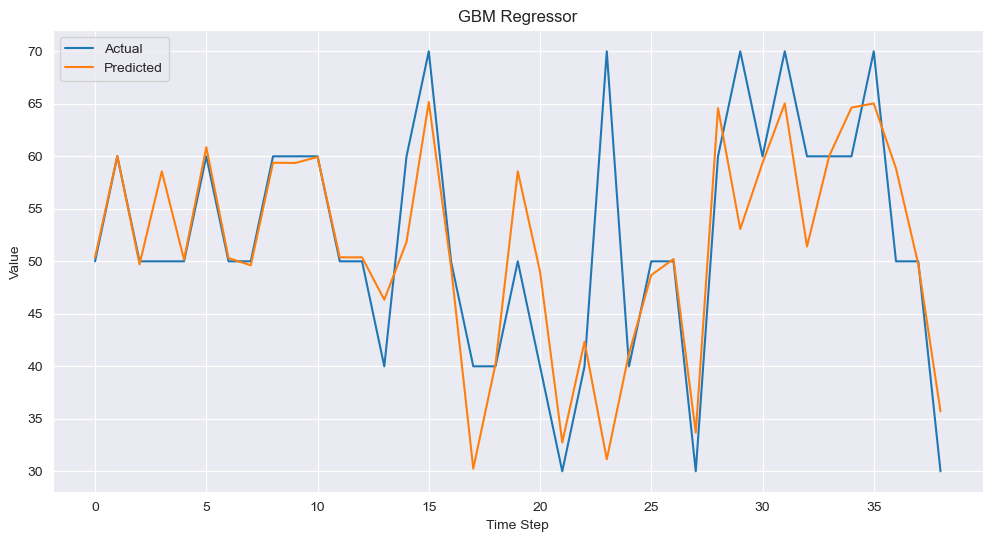

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')  # Ensure y_test is converted to NumPy array
plt.plot(y_pred.flatten(), label='Predicted')
plt.title('GBM Regressor')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

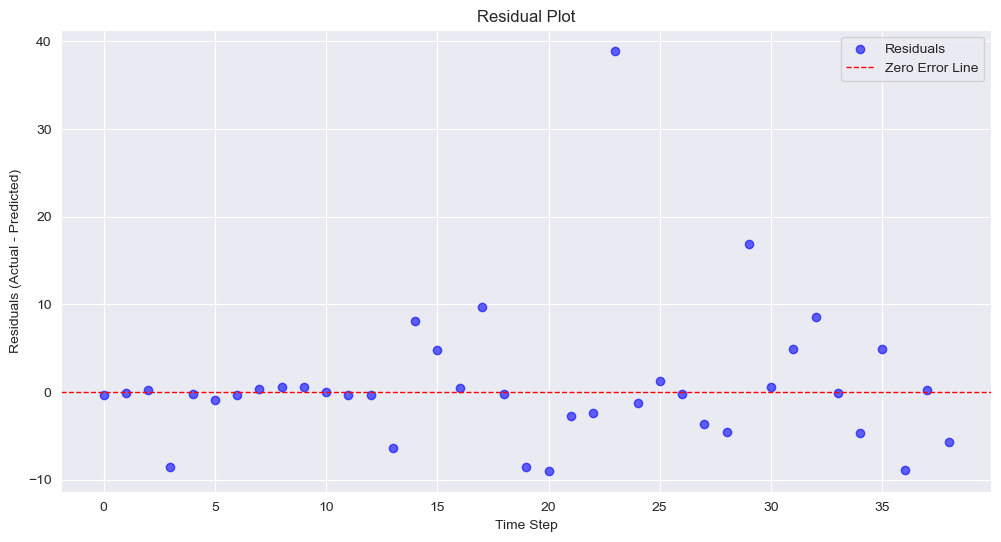

In [16]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='blue', alpha=0.6, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Error Line')
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()